# Extra Factors in the KWN Model

The default options in the KWN model assumes bulk nucleation and a spherical precipitate. However, in real-life systems, these assumptions may not be true. Several options are present to model heterogenous nucleation and non-spherical precipitate shapes.

## Nucleation

The options for the nucleation site density includes the following: 'bulk', 'dislocations', 'grain_boundaries', 'grain_edges', 'grain_corners'

The nucleation site density ($N_0$) for bulk nucleation is determined by the number of solutes in the bulk lattice. For dislocation, $N_0$ depends on the dislocation density. $N_0$ for grain boundaries, edges and corners depends on the grain size [1]. For grain boundary nucleation, the change in surface energy accounts for both the creation of the precipitate/matrix interface and removal of grain boundary, for which the grain boundary energy must be defined [2]. By default, the grain boundary energy is set to 0.3 $J/m^2$.

While the KWNModel will automatically calculate the nucleation site densities for each site type, these values can be manually set.

In [1]:
from kawin.KWNBase import PrecipitateBase

model = PrecipitateBase(t0 = 0, tf = 100, steps = 2e3, linearTimeSpacing = True)

#Change nucleation site type to grain boundaries
model.setNucleationSite('grain_boundaries')

#Set grain boundary energy for nucleation on grain boundaries/edges/corners
model.setGrainBoundaryEnergy(0.3)

#Change dislocation density and grain size
model.setNucleationDensity(grainSize = 10, aspectRatio = 1, dislocationDensity = 5e12)

#Manually set nucleation site density for each site type
model.bulkN0 = 1e30          #Bulk nucleation site density
model.dislocationN0 = 1e30   #Site density on dislocations
model.GBareaN0 = 1e30        #Site density on grain boundaries
model.GBedgeN0 = 1e30        #Site density on grain edges
model.GBcornerN0 = 1e30      #Site density on grain corners

## Shape factors

Currently, the KWN model has support for ellipsoidal (prolate/needle and oblate/plate) and cuboidal precipitates. For cuboidal precipitates the cubic factor currently set constant at $\sqrt{2}$ [3,4]. These shapes are defined in the KWN model by their equivalent spherical radius ($R$) and an aspect ratio ($\alpha$), where the $\alpha$ can either be constant or as a function of $R$.

The aspect ratio is defined as the ratio of the long axis over the short axis. Conversion between the radius along the short axis ($r$) and the equivalent spherical radius ($R$) is given by:

Needle:   $ R = \sqrt[3]{\alpha} r $

Plate:   $ R = \sqrt[3]{\alpha^2} r $

Cuboidal:   $ R = \sqrt[3]{\frac{3 \alpha}{4 \pi}} r $

Deviation from a spherical precipitate changes both the thermodynamics (Gibbs-Thomson effect) and kinetics (growth rate). The free energy contribution from the Gibbs-Thomson effect is given by:

$$ \Delta G_{TH} = g(\alpha) \frac{2 \gamma V_M^\beta}{R} $$

The changes in the growth rate is given by:

$$ \frac{dR}{dt} = f(\alpha) \frac{dR}{dt} \bigg\rvert_{sphere} $$

The functions of $g(\alpha)$ and $f(\alpha)$ are taken from Ref. 3 and 4.

In [2]:
#Change precipitate shape
model.setAspectRatioNeedle(ratio = 1.5)
model.setAspectRatioPlate(ratio = 1.5)
model.setAspectRatioCuboidal(ratio = 1.5)

#Remove aspect ratio and set to spherical shape
model.setSpherical()

#Radius-dependent aspect ratio
ar = lambda r: 2.3 * (r/1e-9)**1.1
model.setAspectRatioNeedle(ratio = ar)

## Strain Energy

Molar volume differences between the matrix and precipitate phase can induce strains, which reduces the driving force for nucleation. For spherical and cuboidal precipitates, the strain energy can be calculated by Khachaturyan's approximation. For ellipsoidal precipitates, the strain energy can be calculated using Eshelby's tensor [4,5].

Similar to the Thermodynamics and Surrogate modules, the strain energy is calculated using a module separated from KWNBase. Inserting the strain energy parameters requires creating and setting up a StrainEnergy object, then inserting it into the KWN model for a specified phase.

The StrainEnergy object requires the elastic constants and eigenstrains to be defined. External stresses can also be defined if applicable. The eigenstrains and external stress can be defined as a tensor (3x3), values along the three axes (array of length 3), or a single value to be applied on all 3 axes. The elastic constants can be defined using its 6x6 tensor, the three elastic constants ($c_{11}$, $c_{12}$ and $c_{44}$), or by at least two moduli (e.g. elastic modulus, poission ratio, shear modulus, bulk modulus, etc.)

In [3]:
from kawin.ElasticFactors import StrainEnergy

#Create StrainEnergy object
se = StrainEnergy()

#Set elastic tensor by its elastic modulus and possion ratio
se.setModuli(E = 100e9, nu = -0.3)

#Set eigenstrains
# [[0.01, 0.00, 0.00]
#  [0.00, 0.01, 0.00]
#  [0.00, 0.00, 0.02]]
se.setEigenstrain([0.01, 0.01, 0.02])

#Insert StrainEnergy object into KWN model
model.setStrainEnergy(se)

# Strain Energy Example (Cu-Ti system)

In the Cu-Ti system (dilute Ti), the needle-like $Cu_4Ti$ precipitate creates lattice strains in the Cu-matrix. The following parameters are applicable to this system (from K. Wu et al (2018)):

Eigenstrains of the $Cu_4Ti$ precipitate:

$ \epsilon_{11} = 0.022 $

$ \epsilon_{22} = 0.022 $

$ \epsilon_{33} = 0.003 $

Elastic constants for the Cu matrix

$ c_{11} = 168.4 \quad GPa $

$ c_{12} = 121.4 \quad GPa $

$ c_{44} = 75.4 \quad GPa $

We can use these values to determine the strain energy of the $Cu_4Ti$ precipitate for any given aspect ratio. In this example, we'll vary the aspect ratio from 1 to 2 and calculate the strain energy. The volume of the precipitate will be set constant to the volume of a sphere with a radius of 4 nm.

We will also apply different stresses (-400 MPa, 0 MPa, 400 MPa) along the first axis ($\sigma_{11} = \sigma^0$).

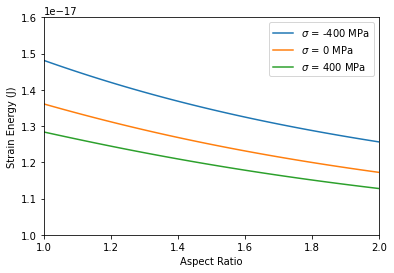

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#By default, StrainEnergy outputs 0
#This is changed within the KWN model before the model is solved for
#However, we can manually change it. For this example, we need to set it to the calculate for ellipsoidal shapes
se.setEllipsoidal()

#Set elastic tensor by c11, c12 and c44 values
se.setElasticConstants(168.4e9, 121.4e9, 75.4e9)

#Set eigenstrains
se.setEigenstrain([0.022, 0.022, 0.003])

#Aspect ratio
aspect = np.linspace(1, 2, 100)
ratio = 4e-9 / np.cbrt(aspect)

#Vary external stress along 1st axis
sig = [-400e6, 0, 400e6]
r = np.array([ratio, ratio, aspect*ratio]).T
for i in range(3):
    se.setAppliedStress([sig[i], 0, 0])
    E = se.strainEnergy(r)
    plt.plot(aspect, E, label=r'$\sigma$ = {:.0f} MPa'.format(sig[i]/1e6))
plt.xlim([1, 2])
plt.ylim([1.0e-17, 1.6e-17])
plt.xlabel('Aspect Ratio')
plt.ylabel('Strain Energy (J)')
plt.legend()
plt.show()

## References

1. Kozeschnik, Ernst et al. Precipitation Modeling, Momentum Press, 2012
2. P. J. Clemm and J. C. Fisher, "The Influence of Grain Boundaries on the Nucleation of Secondary Phases" *Acta Metallurgica* **3** (1955) p. 70
3. B. Holmedal, E. Osmundsen, Q. Du, "Precipitation of Non-Spherical Particles in Aluminum Alloys Part I: Generalization of the Kampmann-Wagner Numerical Model" *Metallurgical and Materials Transactions A* **47** (2016) p. 581
4. K. Wu, Q. Chen and P. Mason, "Simulation of Precipitation Kinetics with Non-Spherical Particles" *J. Phase Equilib. Diffus.* **39** (2018) p. 571
5. C. Weinberger, W. Cai and D. Barnett, ME340B Lecture Notes - Elasticity of Microscopic Structures, Standford University 2005. http://micro.standford.edu/~caiwei/me340b/content/me340b-notes_v01.pdf